## 정밀도와 재현율 Precision and Recall


- 정밀도와 재현율은 Positive 데이터셋의 예측 성능에 초점을 맞춘 평가 지표


##### 정밀도 = TP / (FP + TP) 

* 예측을 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율

##### 재현율(민감도) = TP / (FN + TP)

* 실제값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율


###### 재현율이 중요 지표인 경우

- 실제 positive 양성 데이터를 negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우


- ex) 암 판단 모델: 실제 positive(양성)인 암 환자를 negative(음성)으로 판단하면 심각


- ex) 보험 사기같은 금융 사기 모델: 실제 금융 거래 사기(positive)를 아니라고 판단하면 회사에 손해가 큼

##### 정밀도가 더 중요한 지표인 경우


- ex) 스팸 메일 여부를 판단하는 모델: 실제 스팸메일(positive)을 일반메일(negative)로 분류해도 사용자가 불편함을 느끼는 정도지만 일반메일을 스팸으로 분류해버리면 아예 메일을 못받아서 업무에 차질 생김

- 재현율은 FN을 낮추는데, 정밀도는 FP를 낮추는데 초점을 맞춤

#### 앞의 타이타닉 예제에서 정확도 뿐만아니라 오차 행렬, 정밀도, 재현율을 모두 구해서 성능 평가해보기

In [2]:
from sklearn.preprocessing import LabelEncoder

#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df
    
#머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 정의된 함수들 호출, 전처리 수행하는 함수 생성
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [6]:
#평가를 간편하게 적용하기 위해 matrix, accuracy, precision, recall 등의 평가를 한번에 호출하는 함수 만들기

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

##### 로지스틱 회귀 귀반으로 타이타닉 생존자를 예측하고 평가를 수행

- solver = 'liblinear'은 로지스틱 회귀의 최적화 알고리즘 유형을 지정하는 것, 기본값은 lbfgs이며 데이터셋이 상대적으로 크고 다중 분류인 경우 적합함

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터 재로딩, 가공, 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression(solver = 'liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


### 정밀도/재현율 트레이드오프

- 정밀도와 재현율은 상호보완적인 지표이기 때문에 어느 한 쪽을 높이면 다른 하나는 떨어지는 트레이드 오프(Trade-off)임


1. 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(결정값)에 속하는지 계산하기 위해 개별 레이블별로 결정 확률을 구함 >> predict_proba() 메서드는 학습이 완료된 Classifier 객체에서 호출 가능


2. 예측 확률이 큰 레이블값으로 예측하게 됨


3. 일반적으로 이진 분류에서는 임계값을 0.5(50%)로 정하고 이것보다 확률이 크면 positive, 아니면 negative로 결정

In [11]:
import numpy as np
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합해 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


- 사이킷런은 분류 결정 임계값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있음

#### 사이킷런의 Binarizer 클래스

In [12]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold(임계)값보다 같거나 작으면 0, 크면 1 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


#### Binarizer를 이용해서 predict()의 의사(pseudo) 코드 만들기

In [13]:
from sklearn.preprocessing import Binarizer

#분류 결정 임계값
custom_threshold = 0.5

#predict_proba 반환값의 두번째 칼럼, 즉 positive 칼럼 하나만 추출해서 BInarizer적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)


오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


##### 만일 분류 결정 임계값을 낮추면 어떻게 변할까? 0.4로 낮춰보기

In [14]:
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


- 임계값을 낮추니 재현율이 올라가고 정밀도가 떨어짐 >>> 분류 결정 임계값은 positive 예측값을 결정하는 확률의 기준이 됨. 확률이 0.4부터 positive로 예측하게 되니 True값이 더 많아졌기 때문(재현율 ↑)

##### 임계값을 0.4부터 0.6까지 0.55씩 증가시키며 평가 지표 조사하기

In [15]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임계값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임계값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임계값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임계값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


- 임계값이 올라 갈수록 정밀도는 올라가고 재현율은 떨어짐 >> 디폴트인 0.5와 비교할 때, 정확도는 동일하고 정밀도는 약간 떨어졌으나 재현율아 오른 0.45인 경우가 가장 적당해보임

#### 이와 유사한 precision_recall_curve() API

- 입력 파라미터: y_true(실제 클래스값 배열), probas_pred(Positive 칼럼의 예측 확률 배열)


- 반환값: 정밀도, 재현율


- 일반적으로 0.11~0.95 정도의 임계값을 담은 넘파이 ndarray와 이 임계값에 해당하는 정밀도 및 재현율을 반환함

In [19]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

#실제값 데이터셋과 레이블 값이 1일 때의 예측 확률을 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index], 2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


- 임계값이 증가할수록 정밀도값은 동시에 높아지나 재현율 값은 낮아짐


- 임계값에 따른 값 변화를 시각화할 수 있음

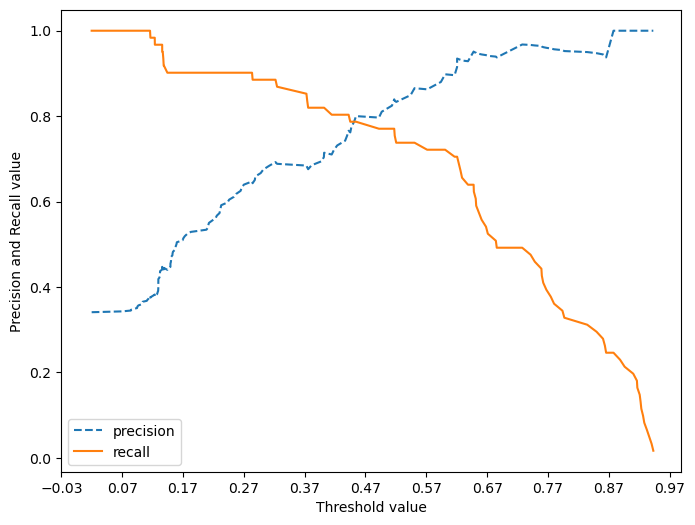

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1])

- 0,45 지점에서 재현율과 정밀도가 비슷함

### 정밀도와 재현율의 맹점


##### 정밀도가 100%되는 방법

- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 negative로 예측함


ex) 환자가 80세 이상이고 비만이며 암 진단을 받은 적이 있고 암세포 크기가 상위 0.1% 이상이면 무조건 Positive, 아니면 Negative


##### 재현율이 100%가 되는 방법

- 모든 환자를 Positive로 예측하면 됨




> 이처럼 정밀도와 재현율 어느 한쪽만 참조하면 극단적인 수치 조작이 가능함. 